In [3]:
!git clone https://github.com/lapudas/GreenAI.git

Cloning into 'GreenAI'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 48 (delta 15), reused 16 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (48/48), 185.23 KiB | 831.00 KiB/s, done.
Resolving deltas: 100% (15/15), done.


In [4]:
%pip install codecarbon
%pip install evaluate
%pip install rouge_score

# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve & ollama pull llama3
# ollama run llama3:8b

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %pip install --user --upgrade --force-reinstall codecarbon

  Using cached codecarbon-3.0.2-py3-none-any.whl.metadata (9.1 kB)
  Using cached arrow-1.3.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached fief_client-0.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached pandas-2.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached prometheus_client-0.22.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached psutil-7.0.0-cp36-abi3-macosx_11_0_arm64.whl.metadata (22 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached pynvml-12.0.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached questionary-2.1.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached rapidfuzz-3.13.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached typer-0.16.0-py3-

In [6]:
from codecarbon import EmissionsTracker
from codecarbon import track_emissions
# Load the ROUGE metric
import evaluate
from evaluate import load
import pandas as pd

In [7]:
!ollama list

NAME             ID              SIZE      MODIFIED     
llama3:8b        365c0bd3c000    4.7 GB    33 hours ago    
llama3:latest    365c0bd3c000    4.7 GB    34 hours ago    


In [8]:
# read files(src)
# 1 document 一行，||||| 分段落
'''f = open("/content/train.src.txt","r")
train_data = f.readlines()
f.close()'''

f = open("test.src.txt","r")
test_data = f.readlines()
f.close()

'''f = open("/content/val.src.txt","r")
val_data = f.readlines()
f.close()'''

print(f"test: {len(test_data)}")#(f"train: {len(train_data)}\ntest: {len(test_data)}\nval: {len(val_data)}")

test: 5622


In [9]:
f = open("test.txt","r")
test_result = f.readlines()
f.close()

print(test_result[0])
print(len(test_result))

– It's a race for the governor's mansion in 11 states today, and the GOP could end the night at the helm of more than two-thirds of the 50 states. The GOP currently controls 29 of the country's top state offices; it's expected to keep the three Republican ones that are up for grabs (Utah, North Dakota, and Indiana), and wrest North Carolina from the Dems. That brings its toll to 30, with the potential to take three more, reports NPR. Races in Montana, New Hampshire, and Washington are still too close to call, and in all three, Democrat incumbents aren't seeking reelection. The results could have a big impact on health care, since a Supreme Court ruling grants states the ability to opt out of ObamaCare's Medicaid expansion. "A Romney victory would dramatically empower Republican governors," said one analyst. Click for NPR's state-by-state breakdown of what could happen.

5622


In [10]:
%pip install transformers datasets accelerate --quiet


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "google/flan-t5-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


In [12]:
from datasets import Dataset
import pandas as pd

# Load the aligned document–summary pairs
def load_txt_pair(document_path, summary_path):
    with open(document_path, "r", encoding="utf-8") as f_doc, open(summary_path, "r", encoding="utf-8") as f_sum:
        documents = [line.strip() for line in f_doc]
        summaries = [line.strip() for line in f_sum]
    
    assert len(documents) == len(summaries), "Mismatch in number of documents and summaries"
    
    data = {"document": documents, "summary": summaries}
    df = pd.DataFrame(data)
    return Dataset.from_pandas(df)

# Example: Load training and validation sets
train_dataset = load_txt_pair("train.src.txt", "train.txt")
val_dataset = load_txt_pair("val.src.txt", "val.txt")

# Combine into Hugging Face DatasetDict
from datasets import DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

dataset


DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 44972
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 5622
    })
})

In [13]:
max_input_length = 1024
max_target_length = 256

def preprocess(example):
    inputs = tokenizer(
        example["document"],
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
    )
    targets = tokenizer(
        example["summary"],
        max_length=max_target_length,
        truncation=True,
        padding="max_length"
    )
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["document", "summary"])


Map:   0%|          | 0/44972 [00:00<?, ? examples/s]

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

In [ ]:
# import torch
# torch.backends.mps.is_available()

# device = "mps" if torch.backends.mps.is_available() else "cpu"
# model.to(device)



In [ ]:
# mac_train.py
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Load tokenizer/model
model_name = "google/flan-t5-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Use MPS if available
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)

# Load .src.txt and .txt files
def load_txt_pair(src_path, tgt_path):
    with open(src_path, "r", encoding="utf-8") as f1, open(tgt_path, "r", encoding="utf-8") as f2:
        docs = [line.strip() for line in f1]
        summaries = [line.strip() for line in f2]
    return docs, summaries

# Custom dataset
class SummaryDataset(Dataset):
    def __init__(self, docs, summaries, tokenizer, max_input=512, max_target=128):
        self.docs = docs
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_input = max_input
        self.max_target = max_target

    def __len__(self):
        return len(self.docs)

    def __getitem__(self, idx):
        x = self.tokenizer(self.docs[idx], max_length=self.max_input, truncation=True, padding="max_length", return_tensors="pt")
        y = self.tokenizer(self.summaries[idx], max_length=self.max_target, truncation=True, padding="max_length", return_tensors="pt")
        x["labels"] = y["input_ids"]
        return {k: v.squeeze() for k, v in x.items()}

# Load your data
train_docs, train_summaries = load_txt_pair("./Data/train.src.txt", "./Data/train.txt")
train_data = SummaryDataset(train_docs, train_summaries, tokenizer)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)   ##change to 4

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.train()

for epoch in range(3):
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {epoch_loss / len(train_loader):.4f}")


Epoch 1: 100%|██████████| 44972/44972 [1:27:50<00:00,  8.53it/s]


Epoch 1 loss: 2.8651


Epoch 2: 100%|██████████| 44972/44972 [1:27:38<00:00,  8.55it/s]


Epoch 2 loss: 2.7620


Epoch 3: 100%|██████████| 44972/44972 [1:27:55<00:00,  8.52it/s]

Epoch 3 loss: 2.7053


In [16]:
import transformers
import evaluate
print("Transformers:", transformers.__version__)
print("Evaluate:", evaluate.__version__)


Transformers: 4.53.2
Evaluate: 0.4.5


In [ ]:
import evaluate
import numpy as np

from datasets import Dataset
import pandas as pd

def load_test_pair(src_path, tgt_path):
    with open(src_path, "r", encoding="utf-8") as f1, open(tgt_path, "r", encoding="utf-8") as f2:
        docs = [line.strip() for line in f1]
        summaries = [line.strip() for line in f2]
    assert len(docs) == len(summaries), "Mismatch in lengths!"
    df = pd.DataFrame({"document": docs, "summary": summaries})
    return Dataset.from_pandas(df)

test_dataset = load_test_pair("./Data/test.src.txt", "./Data/test.txt")

predictions = []
references = []

for example in tqdm(test_dataset, desc="Generating summaries..."): #test_dataset:  ## for showing the progress bar
    input_text = example["document"]
    target_text = example["summary"]

    input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).input_ids.to(model.device)
    output_ids = model.generate(input_ids, max_new_tokens=128)
    pred_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    predictions.append(pred_text)
    references.append(target_text)


ROUGE scores:
rouge1: 0.3112
rouge2: 0.0928
rougeL: 0.1787
rougeLsum: 0.1786

BLEU score:
BLEU: 0.0281


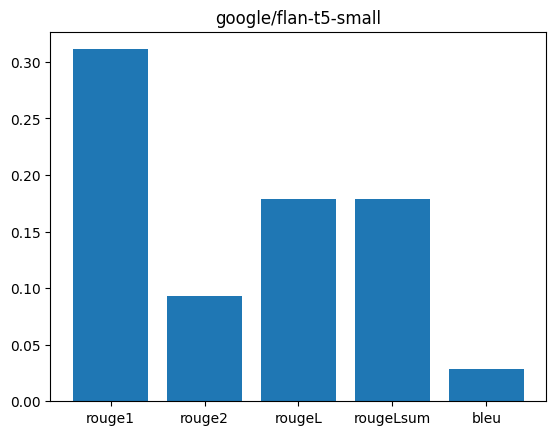

In [ ]:

rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# ROUGE expects a list of predictions and references
rouge_scores = rouge.compute(predictions=predictions, references=references)
print("ROUGE scores:")
for k, v in rouge_scores.items():
    print(f"{k}: {v:.4f}")

# BLEU expects list of tokenized hypotheses and references
bleu_score = bleu.compute(
    predictions=predictions,
    references=references
)

print("\nBLEU score:")
print(f"BLEU: {bleu_score['bleu']:.4f}")

import matplotlib.pyplot as plt

x = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'bleu']
y = [rouge_scores[r] for r in x[:4]] + [bleu_score['bleu']]
plt.bar(x,y)
plt.title("google/flan-t5-xl")
plt.show()


In [ ]:
# from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

# training_args = Seq2SeqTrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     weight_decay=0.01,
#     save_total_limit=2,
#     num_train_epochs=3,
#     predict_with_generate=True,
#     fp16=False,
#     bf16=False,
# )

# trainer = Seq2SeqTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_dataset["train"],
#     eval_dataset=tokenized_dataset["validation"],
#     tokenizer=tokenizer,
#     data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
# )


/Users/lulu/miniconda3/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/0v/l31l6_9s7f9dt6_lz5qrx6g40000gq/T/ipykernel_25270/3946768562.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


ValueError: fp16 mixed precision requires a GPU (not 'mps').

In [ ]:
# trainer.train()
sample = dataset["validation"][0]
input_ids = tokenizer(sample["document"], return_tensors="pt", truncation=True, max_length=1024).input_ids
output = model.generate(input_ids, max_new_tokens=200)
print("Model summary:", tokenizer.decode(output[0], skip_special_tokens=True))
print("Reference summary:", sample["summary"])


### original code

In [ ]:
import requests
import re

def preprocess(text):
  # Replace placeholder newline tokens
  text = text.replace("NEWLINE_CHAR", "\n")
  # Remove duplicate credits or captions
  #text = re.sub(r"(jim cole\s*/\s*ap\s*)+", "", text, flags=re.IGNORECASE)
  # Normalize whitespace and lowercase
  #text = re.sub(r"\s+", " ", text).strip().lower()
  return text

def chat_with_ollama(document, model="llama3:8b"):
  url = "http://localhost:11434/api/chat"
  headers = {"Content-Type": "application/json"}
  system_prompt = {
    "role": "system",
    "content": (
      "Summarize the following article into clear and concise sentences. "
      "Output only the summary. Do not include any explanation or headings."
    )
  }

  document_parts = document.split("|||||")
  summaries = []

  for part in document_parts:
    part = preprocess(part)
    if not part.strip():
      continue
    data = {
      "model": model,
      "messages": [system_prompt, {"role": "user", "content": part}],
      "stream": False
    }
    response = requests.post(url, headers=headers, json=data)
    result = response.json()
    summaries.append(result["message"]["content"])

  # Combine summaries
  combine_prompt = {
    "role": "system",
    "content": "Combine the following summaries into a single concise summary. Output only the summary itself."
  }
  combined_input = "\n".join(summaries)
  data = {
    "model": model,
    "messages": [combine_prompt, {"role": "user", "content": combined_input}],
    "stream": False
  }
  response = requests.post(url, headers=headers, json=data)
  result = response.json()
  return result["message"]["content"]

# print(test_data[0])
# print(chat_with_ollama(test_data[0]))

In [ ]:
# import os

# cpu_power_path = "/usr/local/lib/python3.11/dist-packages/codecarbon/data/hardware/cpu_power.csv"
# os.makedirs(os.path.dirname(cpu_power_path), exist_ok=True)

# with open(cpu_power_path, "w") as f:
#     f.write("Name,TDP,TDP_min,TDP_max,sockets\n")
#     f.write("intel xeon 2.00ghz,85,80,95,1\n")  # placeholder values


PermissionError: [Errno 13] Permission denied: '/usr/local/lib'

In [ ]:
candidates = []
data_num = 1000

@track_emissions()
def summarize():
    for document in test_data[:data_num]:
        candidates.append(chat_with_ollama(document))

summarize()

[codecarbon WARNING @ 13:37:39] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:37:39] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 13:37:39] [setup] RAM Tracking...
[codecarbon INFO @ 13:37:39] [setup] CPU Tracking...
[codecarbon WARNING @ 13:37:39] We saw that you have a Apple M2 Max but we don't know it. Please contact us.
[codecarbon WARNING @ 13:37:40] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 13:37:40] CPU Model on constant consumption mode: Apple M2 Max
[codecarbon WARNING @ 13:37:40] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:37:40] [setup] GPU Tracking...
[codecarbon INFO @ 13:37:40] No GPU found.
[codecarbon INFO @ 13:37:40] The below tracking methods have been set up:
    

In [ ]:
references = [i.strip("– ") for i in test_result[:data_num]]
print(references[0])

It's a race for the governor's mansion in 11 states today, and the GOP could end the night at the helm of more than two-thirds of the 50 states. The GOP currently controls 29 of the country's top state offices; it's expected to keep the three Republican ones that are up for grabs (Utah, North Dakota, and Indiana), and wrest North Carolina from the Dems. That brings its toll to 30, with the potential to take three more, reports NPR. Races in Montana, New Hampshire, and Washington are still too close to call, and in all three, Democrat incumbents aren't seeking reelection. The results could have a big impact on health care, since a Supreme Court ruling grants states the ability to opt out of ObamaCare's Medicaid expansion. "A Romney victory would dramatically empower Republican governors," said one analyst. Click for NPR's state-by-state breakdown of what could happen.



In [ ]:
# rouge
rouge = evaluate.load('rouge')
results_R = rouge.compute(predictions=candidates, references=references) #結果平均

print("ROUGE:")
print(f"rouge1: {results_R['rouge1']}\nrouge2: {results_R['rouge2']}\nrougeL: {results_R['rougeL']}\nrougeLsum: {results_R['rougeLsum']}")

ROUGE:
rouge1: 0.2187618303221118
rouge2: 0.0669147834401836
rougeL: 0.13174067497615238
rougeLsum: 0.1322941994196533


In [ ]:
# bleu
# 不需要 brevity_prnalty，可能要考慮手動算 bleu(無BP)
bleu = evaluate.load('bleu')
results_B = bleu.compute(predictions=candidates, references=references)
print("BLEU:")
print(f"bleu: {results_B['bleu']}\nprecisions: {results_B['precisions']}\nbrevity_penalty: {results_B['brevity_penalty']}\nlength_ratio: {results_B['length_ratio']}\ntranslation_length: {results_B['translation_length']}\nreference_length: {results_B['reference_length']}")

BLEU:
bleu: 0.003563374803844726
precisions: [0.5746441042170293, 0.16220257088157536, 0.05972699414987464, 0.026114107294919104]
brevity_penalty: 0.032451581896618155
length_ratio: 0.22583528117695587
translation_length: 55845
reference_length: 247282


In [ ]:
'''results_R = {}
results_R['rouge1'] = 0.3042215287471872
results_R['rouge2'] = 0.08818775179799443
results_R['rougeL'] =  0.1639229255348068
results_R['rougeLsum'] = 0.16663142006267556

results_B = {}
results_B['bleu'] = 0.02515597115661552

print(results_R)'''

"results_R = {}\nresults_R['rouge1'] = 0.3042215287471872\nresults_R['rouge2'] = 0.08818775179799443\nresults_R['rougeL'] =  0.1639229255348068\nresults_R['rougeLsum'] = 0.16663142006267556\n\nresults_B = {}\nresults_B['bleu'] = 0.02515597115661552\n\nprint(results_R)"

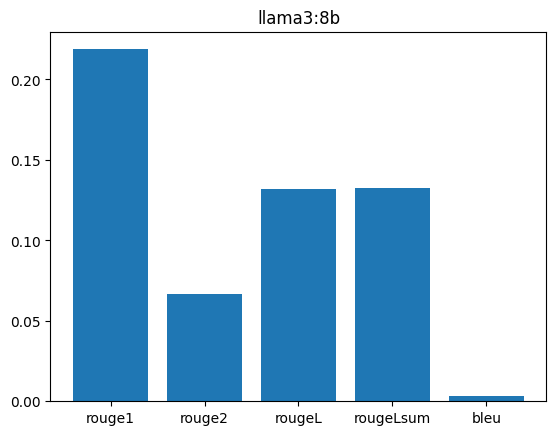

In [ ]:
import matplotlib.pyplot as plt

x = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'bleu']
y = [results_R[r] for r in x[:4]] + [results_B['bleu']]
plt.bar(x,y)
plt.title("llama3:8b")
plt.show()